<a href="https://colab.research.google.com/github/souravagro/PSGan-Family/blob/master/Copy_of_PanColorGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PanColorization GAN

Colab Notebook for Pansharpening Demo with PanColorization GAN

Ozcelik, F., Alganci, U., Sertel, E., & Unal, G. (2020). Rethinking CNN-Based Pansharpening: Guided Colorization of Panchromatic Images via GANs. arXiv preprint arXiv:2006.16644. Arxiv Link

In [ ]:
!git clone https://github.com/ozcelikfu/PanColorGAN.git
!cp PanColorGAN/*.py ./
!gdown --id 1F4iCyeC_5OXWada3UW780YgXx-63GQno --output PanColorGANRD.pth

fatal: destination path 'PanColorGAN' already exists and is not an empty directory.
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1F4iCyeC_5OXWada3UW780YgXx-63GQno
To: /content/PanColorGANRD.pth
100% 32.7M/32.7M [00:00<00:00, 293MB/s]


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from networks import define_G
from util import patch_sixteen, divide_sixteen, show_image, scale_range
import torch.backends.cudnn as cudnn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#@title #**Upload MS and PAN Images** { display-mode: "form" }
from google.colab import files
import tifffile

ms_filename = '/content/PanColorGAN/data/ms1.npy'
pan_filename = '/content/PanColorGAN/data/pan1.npy'
ms = np.load(ms_filename).astype(np.float32)
pan = np.load(pan_filename).astype(np.float32)
print(ms.shape,pan.shape)

(416, 416, 4) (750, 750)


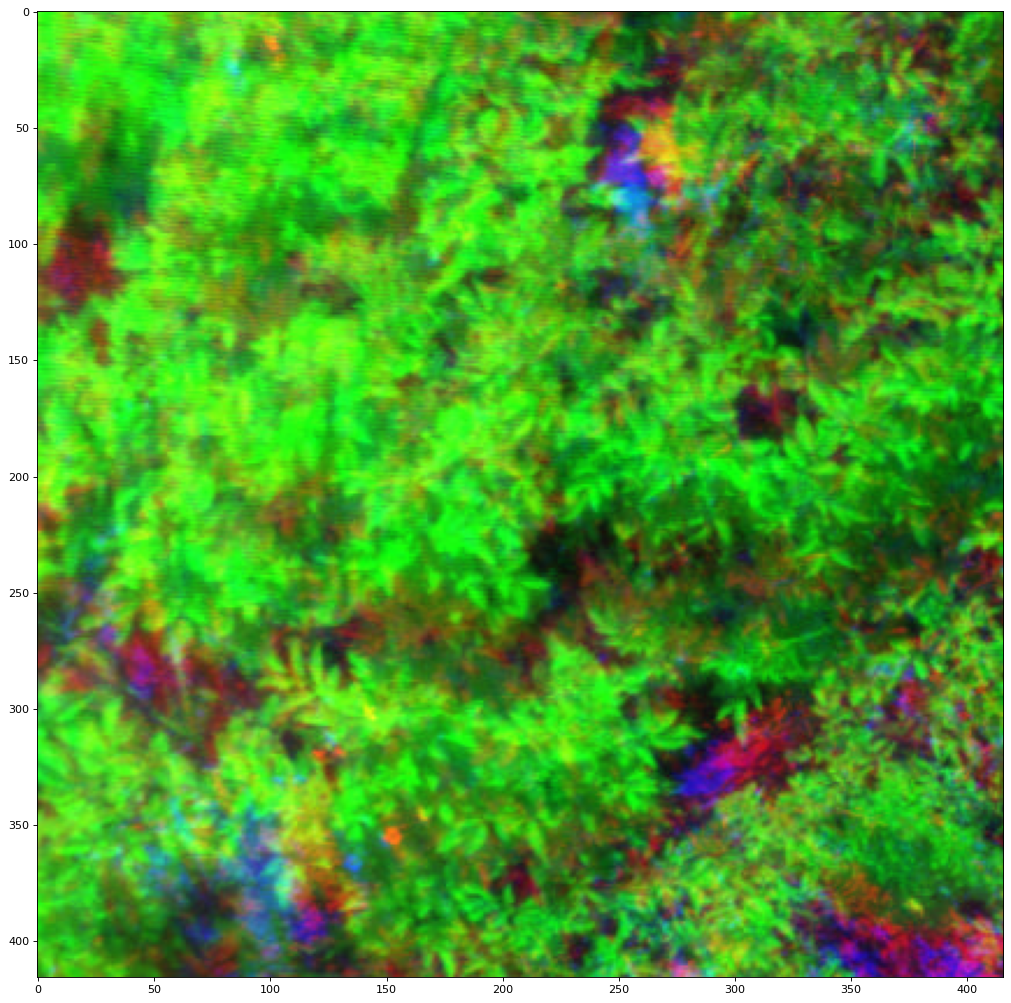

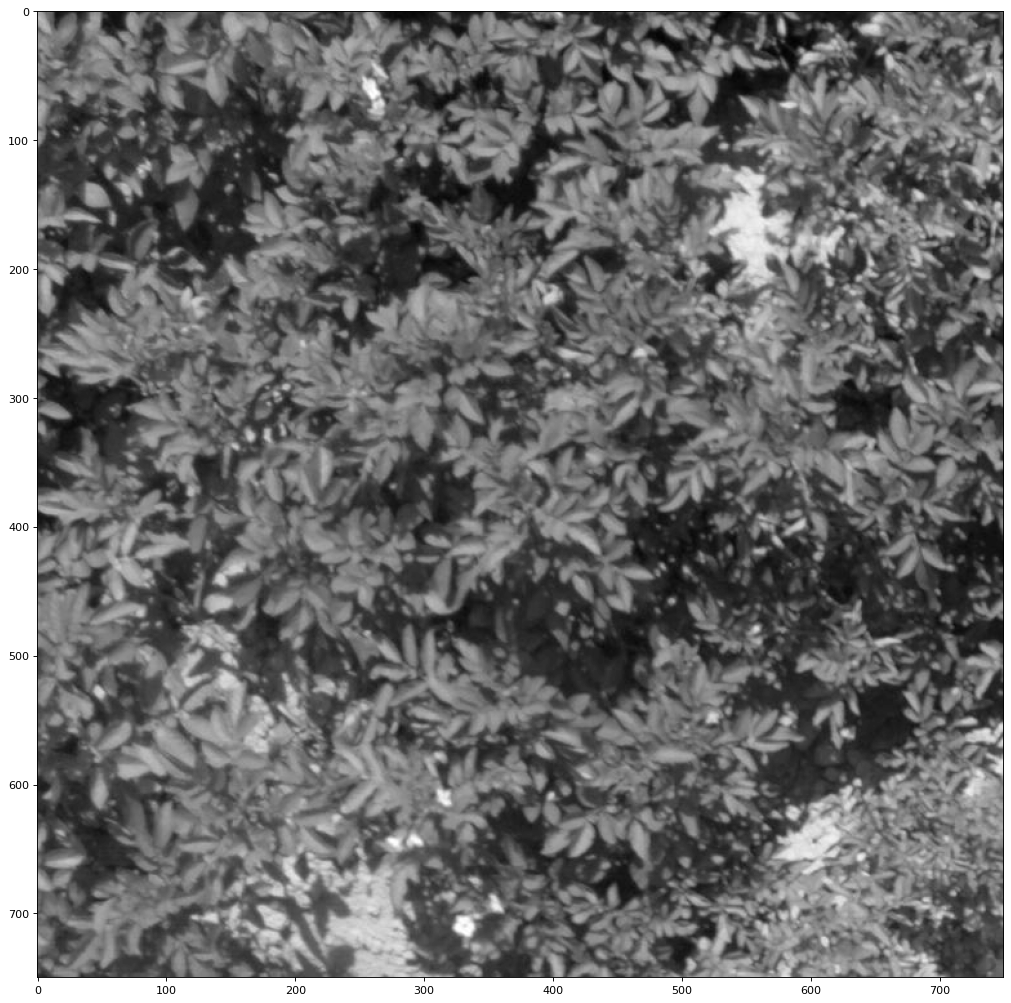

In [ ]:
## Data Display

show_image(ms)
show_image(pan)

In [ ]:
## Parameters
#@title Parameters { display-mode: "form" }
reduced_res=True #@param {type:"boolean"}
use_gpu=False #@param {type:"boolean"}

In [ ]:
## Data Preprocessing
from skimage.transform import resize
ms_norm = np.array([scale_range(i, -1, 1) for i in ms.transpose((2,0,1))])
pan_norm = scale_range(pan, -1, 1)

if reduced_res:
  ms_down = [resize(i,(64,64), 3) for i in ms_norm]
  ms_up = [resize(i, (256, 256), 3) for i in ms_down]
  ms_norm = np.clip(ms_up,-1.0,1.0)
  pan_down = resize(pan_norm, (256, 256), 3)
  pan_norm = np.clip(pan_down,-1.0,1.0)
else: 
  ms_up = [resize(i, (1024, 1024), 3) for i in ms_norm]
  ms_norm = np.clip(ms_up,-1.0,1.0)

inp = np.concatenate((ms_norm,np.expand_dims(pan_norm,axis=0)),axis=0)
if not reduced_res:
  inp = divide_sixteen(inp)
inp = torch.tensor(inp)

In [ ]:
## Network Preparation
model_weights = "/content/PanColorGANRD.pth"
netG = define_G(5, 4, 32, 'batch','leakyrelu', False, 'ResizeConv', 'colorunet', 'SE', 6, [0], n_downsampling=2)
#netG.load_state_dict(torch.load(model_weights, map_location=lambda storage, loc: storage))
netG.load_state_dict(torch.load(model_weights))
netG.eval()
if use_gpu:
  netG = netG.cuda()
else:
  netG = netG.cpu()

In [ ]:
if use_gpu:
  out = netG(inp.cuda().view(-1,5,256,256)).detach().cpu().numpy()
else:
  out = netG(inp.view(-1,5,256,256)).detach().numpy()

In [ ]:
if not reduced_res:
  out = patch_sixteen(out)

(256, 256, 4)


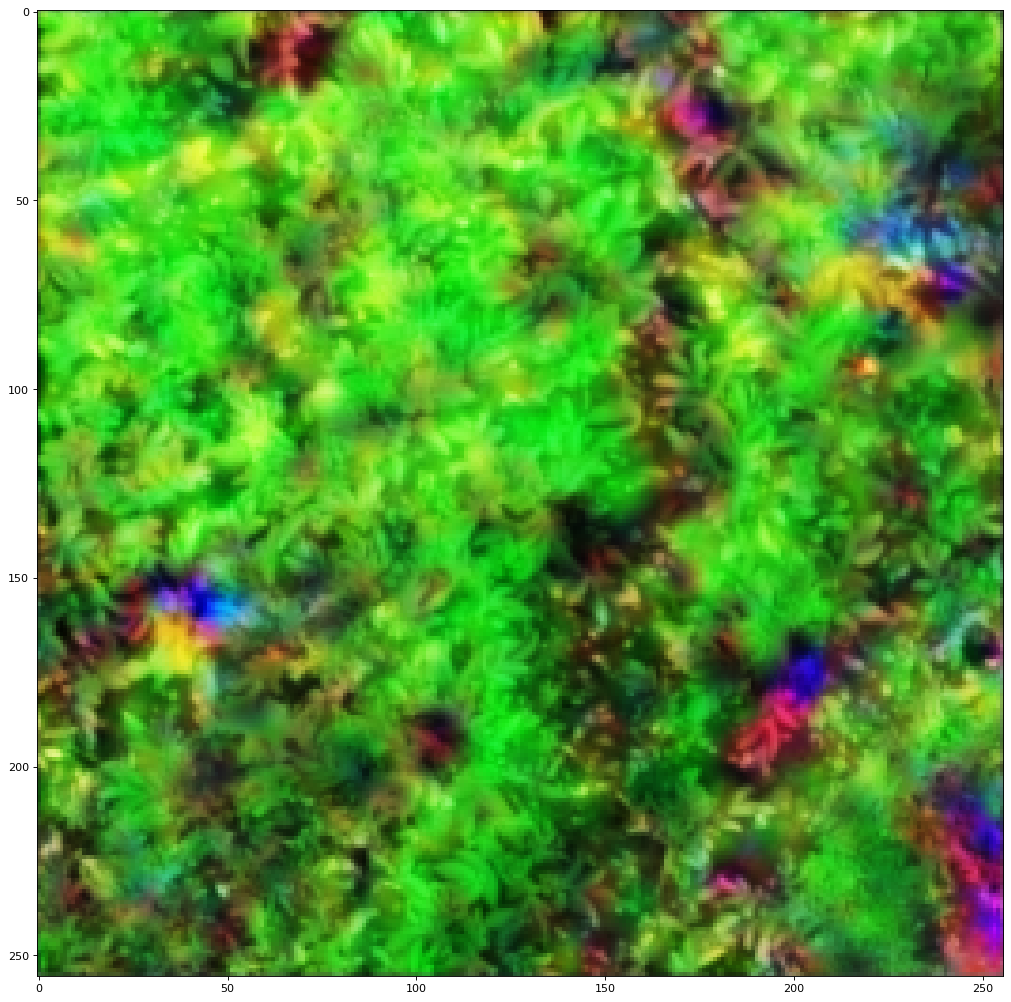

In [ ]:
from PIL import Image
import PIL
import cv2
image = (out.squeeze()*255).astype(np.float32)

i=image.transpose(2,1,0)
print(i.shape)
show_image(i)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
